# Import python library

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Suppress warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Sklearn pre-processing

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [4]:
seed = 10

# Training data

In [5]:
app_train = pd.read_csv('dataset/application_train.csv')
print('Training data shape: ', app_train.shape)

Training data shape:  (307511, 122)


# Testing data features

In [6]:
app_test = pd.read_csv('dataset/application_test.csv')
print('Testing data shape: ', app_test.shape)

Testing data shape:  (48744, 121)


# Function to calculate missing values by column

In [7]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# Missing values statistics

In [8]:
missing_values = missing_values_table(app_train)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


# Create a label encoder object

In [9]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns

In [10]:
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1

In [11]:
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


# one-hot encoding of categorical variables

In [12]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [13]:
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [14]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes

In [15]:
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in

In [16]:
app_train['TARGET'] = train_labels

In [17]:
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


# Data Pre-processing
# Find correlations with the target and sort

In [18]:
correlations = app_train.corr()['TARGET'].sort_values()

In [19]:
# Display correlations

In [20]:
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.04620

In [21]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_3', 'EXT_SOURCE_2','EXT_SOURCE_1', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education', 'DAYS_LAST_PHONE_CHANGE']]
ext_data_corrs = ext_data.corr()

# Heatmap of correlations

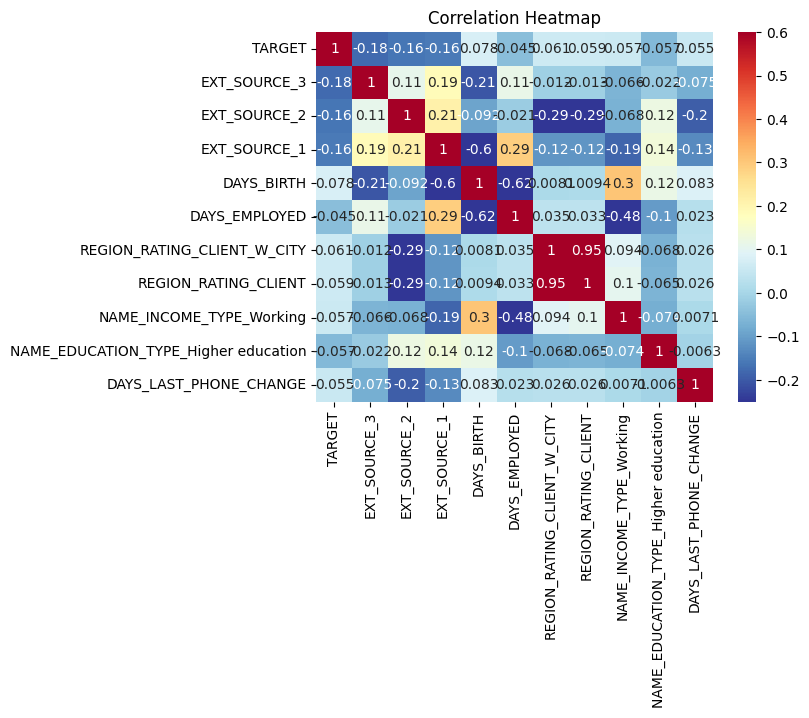

In [22]:
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [23]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_3', 'EXT_SOURCE_2','EXT_SOURCE_1', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY']]

In [24]:
poly_features_test = app_test[['EXT_SOURCE_3', 'EXT_SOURCE_2','EXT_SOURCE_1', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY']]

In [25]:
print(ext_data.shape)
print(poly_features_test.shape)

(307511, 6)
(48744, 5)


# Drop the target from the training data

In [26]:
trainY = ext_data['TARGET']

In [27]:
if 'TARGET' in ext_data:
    trainX = ext_data.drop(columns = ['TARGET'])
else:
    trainX = ext_data.copy()

# Feature names

In [28]:
features = list(trainX.columns)

# Median imputation of missing values

In [29]:
imputer = SimpleImputer(strategy = 'median')

# Fit on the training data

In [30]:
imputer.fit(trainX)

SimpleImputer(strategy='median')

# Transform both training and testing data

In [31]:
trainX = imputer.transform(trainX)
test = imputer.transform(poly_features_test)

In [32]:
new_app_train = pd.DataFrame(data=trainX[:,:], columns=features[:])
new_app_train['TARGET'] = trainY

In [33]:
new_app_test = pd.DataFrame(data=test[:,:], columns=features[:])

In [34]:
print(new_app_train.shape)
print(new_app_test.shape)

(307511, 6)
(48744, 5)


# Make a new dataframe for polynomial features

In [35]:
poly_features = new_app_train
poly_features_test = new_app_test

In [36]:
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

In [37]:
print('Polynomial Features shape: ', poly_features.shape)
print('Polynomial Target shape: ', poly_target.shape)
print('Polynomial Test shape: ', poly_features_test.shape)

Polynomial Features shape:  (307511, 5)
Polynomial Target shape:  (307511,)
Polynomial Test shape:  (48744, 5)


In [38]:
from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree

In [39]:
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features

In [40]:
poly_transformer.fit(poly_features)

PolynomialFeatures(degree=3)

# Transform the features

In [41]:
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

In [42]:
print('Polynomial Features shape: ', poly_features.shape)
print('Polynomial Target shape: ', poly_target.shape)
print('Polynomial Test shape: ', poly_features_test.shape)

Polynomial Features shape:  (307511, 56)
Polynomial Target shape:  (307511,)
Polynomial Test shape:  (48744, 56)


In [43]:
poly_features = pd.DataFrame(poly_features, columns = poly_transformer.get_feature_names(['EXT_SOURCE_3', 'EXT_SOURCE_2','EXT_SOURCE_1', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY']))

# Add in the target

In [44]:
poly_features['TARGET'] = poly_target

# Find the correlations with the target

In [45]:
poly_corrs = poly_features.corr()['TARGET'].sort_values()

In [46]:
print('Polynomial Features shape: ', poly_features.shape)
print('Polynomial Target shape: ', poly_target.shape)
print('Polynomial Test shape: ', poly_features_test.shape)

Polynomial Features shape:  (307511, 57)
Polynomial Target shape:  (307511,)
Polynomial Test shape:  (48744, 56)


# Heatmap of correlations

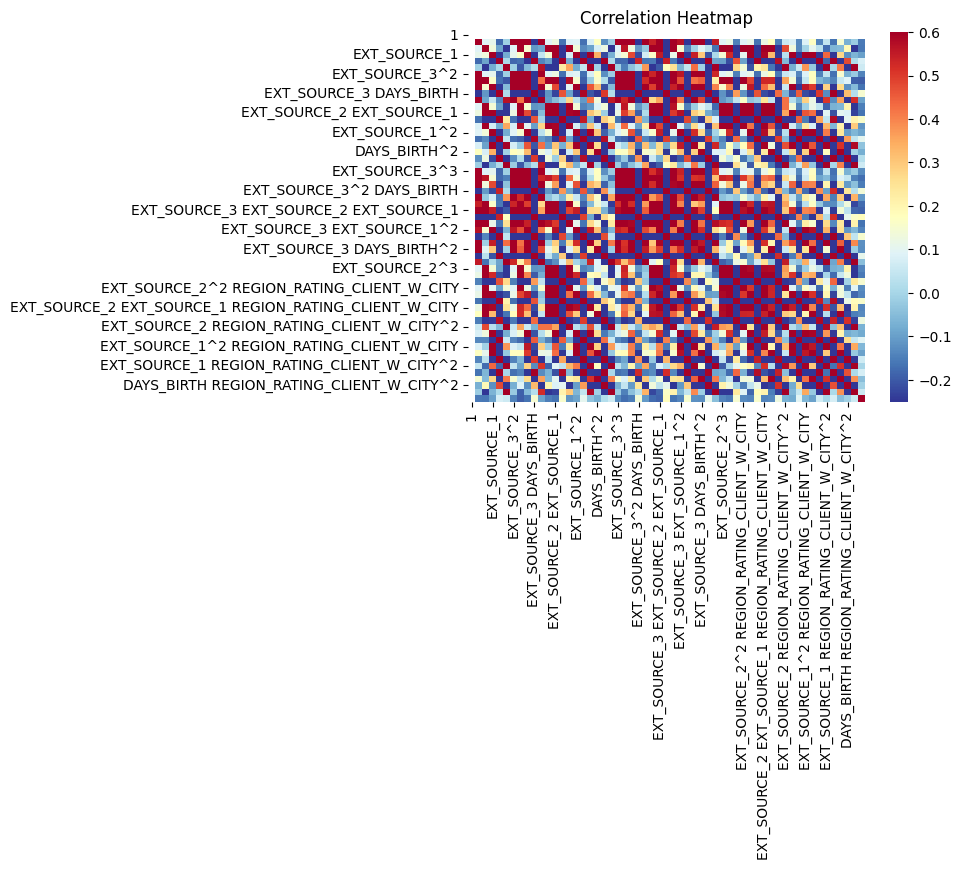

In [47]:
sns.heatmap(poly_features.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = False, vmax = 0.6)
plt.title('Correlation Heatmap');

# Display most negative and most positive

In [48]:
print("Most Negative Correlations:")
print(poly_corrs.head(10))
print("\nMost Positive Correlations:")
print(poly_corrs.tail(10))

Most Negative Correlations:
EXT_SOURCE_3 EXT_SOURCE_2                               -0.193939
EXT_SOURCE_3 EXT_SOURCE_2 EXT_SOURCE_1                  -0.189605
EXT_SOURCE_3 EXT_SOURCE_2^2                             -0.176428
EXT_SOURCE_3^2 EXT_SOURCE_2                             -0.172282
EXT_SOURCE_2 EXT_SOURCE_1                               -0.166625
EXT_SOURCE_3 EXT_SOURCE_2 REGION_RATING_CLIENT_W_CITY   -0.165126
EXT_SOURCE_3 EXT_SOURCE_1                               -0.164065
EXT_SOURCE_2                                            -0.160295
EXT_SOURCE_2^2 EXT_SOURCE_1                             -0.156867
EXT_SOURCE_3                                            -0.155892
Name: TARGET, dtype: float64

Most Positive Correlations:
EXT_SOURCE_2 DAYS_BIRTH REGION_RATING_CLIENT_W_CITY    0.126300
EXT_SOURCE_3^2 DAYS_BIRTH                              0.141777
EXT_SOURCE_2^2 DAYS_BIRTH                              0.149313
EXT_SOURCE_3 DAYS_BIRTH                                0.15010

In [49]:
trainY_poly = poly_features['TARGET']

In [50]:
if 'TARGET' in poly_features:
    trainX_poly = poly_features.drop(columns = ['TARGET'])
else:
    trainX_poly = poly_features.copy()

# Feature names

In [51]:
features = list(trainX_poly.columns)

# Copy of the testing data

In [52]:
test_poly = poly_features_test.copy()

# Median imputation of missing values

In [53]:
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1

In [54]:
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data

In [55]:
imputer.fit(trainX_poly)

SimpleImputer(strategy='median')

# Transform both training and testing data

In [56]:
trainX_poly = imputer.transform(trainX_poly)
test_poly = imputer.transform(test_poly)

# Repeat with the scaler

In [57]:
scaler.fit(trainX_poly)
trainX_poly = scaler.transform(trainX_poly)
test = scaler.transform(test_poly)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(trainX_poly, trainY_poly, test_size=0.33, random_state=seed)

In [59]:
print(trainX_poly.shape)
print(trainY_poly.shape)

(307511, 56)
(307511,)


In [60]:
print(X_train.shape)
print(y_train.shape)

(206032, 56)
(206032,)


# SMOTE sampling

In [61]:
from imblearn.over_sampling import SMOTE

In [62]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [63]:
X_train = X_train_res
y_train = y_train_res

In [64]:
print(X_train.shape)
print(y_train.shape)

(378816, 56)
(378816,)


In [65]:
from xgboost import XGBClassifier

# Train XGBClassifier

In [66]:
boost = XGBClassifier(n_estimators=100)
boost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

# Get prediction accuracy

In [67]:
crossVal = cross_val_score(boost, X_train, y_train, cv=5)
print("Training Cross Validation: %0.2f" % (sum(crossVal) / float(len(crossVal)) * 100), "%")
accuracy = boost.score(X_test, y_test)
print("Test Accuraccy: %0.2f" % (accuracy * 100), "%")

Training Cross Validation: 74.67 %
Test Accuraccy: 72.82 %


# F1 Score

In [68]:
y_predicted = boost.predict(X_test)
print("F1 Score: %0.2f" % f1_score(y_test, y_predicted))

F1 Score: 0.25


# Confusion Matrix

In [69]:
boost_confusion = metrics.confusion_matrix(y_test, y_predicted)

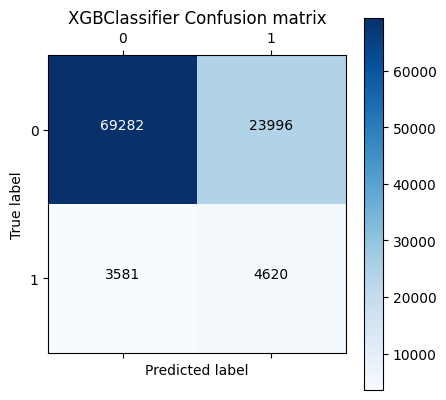

In [70]:
plt.matshow(boost_confusion, cmap=plt.cm.Blues)
plt.grid(b=False)
plt.title("XGBClassifier Confusion matrix")
plt.colorbar()
thresh = boost_confusion.max() / 2.
for i, j in itertools.product(range(boost_confusion.shape[0]), range(boost_confusion.shape[1])):
    plt.text(j, i, boost_confusion[i, j],
    horizontalalignment="center",
    color="white" if boost_confusion[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')

scores = boost.predict_proba(X_test)[:, 1]

# Roc graph 

In [71]:
fpr, tpr, _ = metrics.roc_curve(y_test, scores)
roc_auc = metrics.auc(fpr, tpr)

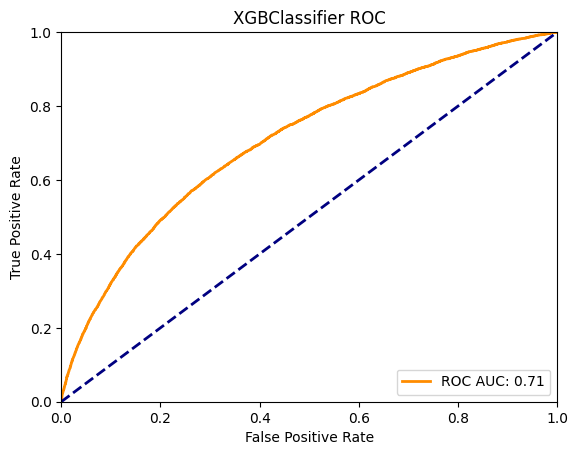

In [72]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC AUC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBClassifier ROC')
plt.legend(loc="lower right")
plt.show()

In [73]:
log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.0001)

# Get prediction accuracy

In [74]:
crossVal = cross_val_score(log_reg, X_train, y_train, cv=5)
print("Training Cross Validation: %0.2f" % (sum(crossVal) / float(len(crossVal)) * 100), "%")
accuracy = log_reg.score(X_test, y_test)
print("Test Accuraccy: %0.2f" % (accuracy * 100), "%")

Training Cross Validation: 66.18 %
Test Accuraccy: 64.40 %


# F1 Score

In [75]:
y_predicted = log_reg.predict(X_test)
print("F1 Score: %0.2f" % f1_score(y_test, y_predicted))

F1 Score: 0.24


# Confusion Matrix

In [76]:
log_reg_confusion = metrics.confusion_matrix(y_test, y_predicted)

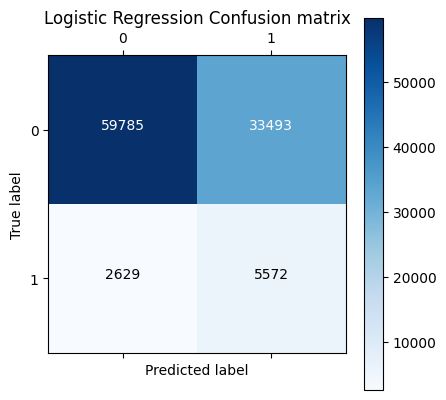

In [77]:
plt.matshow(log_reg_confusion, cmap=plt.cm.Blues)
plt.grid(b=False)
plt.title("Logistic Regression Confusion matrix")
plt.colorbar()
thresh = log_reg_confusion.max() / 2.
for i, j in itertools.product(range(log_reg_confusion.shape[0]), range(log_reg_confusion.shape[1])):
    plt.text(j, i, log_reg_confusion[i, j],
    horizontalalignment="center",
    color="white" if log_reg_confusion[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')

scores = log_reg.predict_proba(X_test)[:, 1]

# Roc graph 

In [78]:
fpr, tpr, _ = metrics.roc_curve(y_test, scores)
roc_auc = metrics.auc(fpr, tpr)

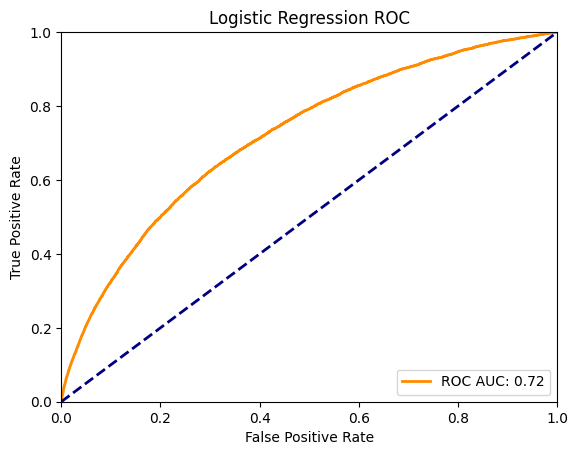

In [79]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC AUC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC')
plt.legend(loc="lower right")
plt.show()

# Train decision tree

In [80]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

# Get prediction accuracy

In [81]:
crossVal = cross_val_score(dt, X_train, y_train, cv=5)
print("Training Cross Validation: %0.2f" % (sum(crossVal) / float(len(crossVal)) * 100), "%")
accuracy = dt.score(X_test, y_test)
print("Test Accuraccy: %0.2f" % (accuracy * 100), "%")

Training Cross Validation: 81.64 %
Test Accuraccy: 76.79 %


# F1 Score

In [82]:
y_predicted = dt.predict(X_test)
print("F1 Score: %0.2f" % f1_score(y_test, y_predicted))

F1 Score: 0.18


# Confusion Matrix

Text(0.5, 0, 'Predicted label')

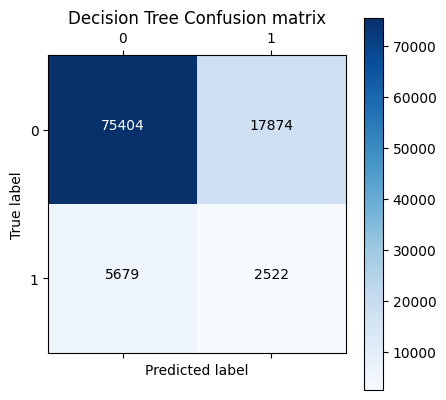

In [83]:
dt_confusion = metrics.confusion_matrix(y_test, y_predicted)
#dt_confusion = dt_confusion.astype('float') / dt_confusion.sum(axis=1)[:, np.newaxis]
plt.matshow(dt_confusion, cmap=plt.cm.Blues)
plt.grid(b=False)
plt.title("Decision Tree Confusion matrix")
plt.colorbar()
thresh = dt_confusion.max() / 2.
for i, j in itertools.product(range(dt_confusion.shape[0]), range(dt_confusion.shape[1])):
    plt.text(j, i, dt_confusion[i, j],
    horizontalalignment="center",
    color="white" if dt_confusion[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Roc graph 

In [84]:
scores = dt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, scores)
roc_auc = metrics.auc(fpr, tpr)

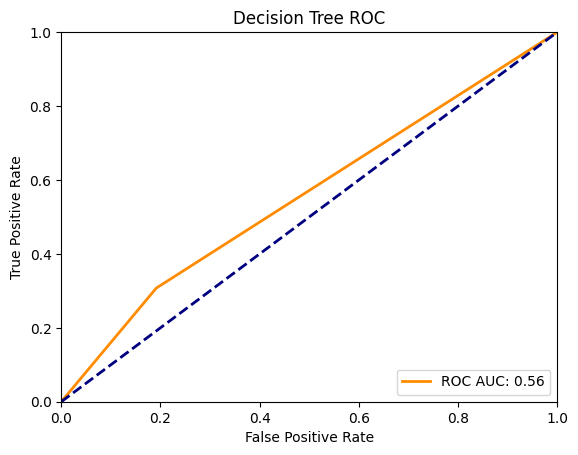

In [85]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC AUC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC')
plt.legend(loc="lower right")
plt.show()

# Train SVM

In [86]:
SVM = svm.LinearSVC()
SVM.fit(X_train, y_train)

LinearSVC()

# Get prediction accuracy

In [87]:
crossVal = cross_val_score(SVM, X_train, y_train, cv=5)
print("Training Cross Validation: %0.2f" % (sum(crossVal) / float(len(crossVal)) * 100), "%")
accuracy = SVM.score(X_test, y_test)
print("Test Accuraccy: ", accuracy * 100, "%")

Training Cross Validation: 66.59 %
Test Accuraccy:  67.19616866543817 %


# F1 Score

In [88]:
y_predicted = SVM.predict(X_test)
print("F1 Score: ",f1_score(y_test, y_predicted))

F1 Score:  0.24485629380940502


# Confusion Matrix

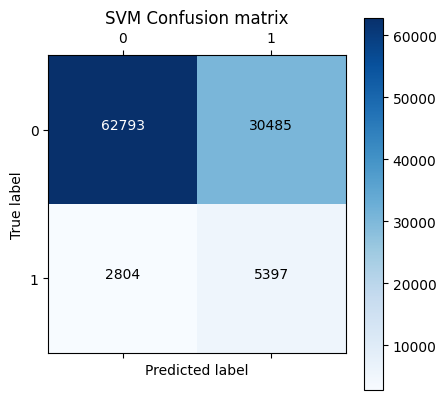

In [89]:
SVM_confusion = metrics.confusion_matrix(y_test, y_predicted)
#SVM_confusion = SVM_confusion.astype('float') / SVM_confusion.sum(axis=1)[:, np.newaxis]
plt.matshow(SVM_confusion, cmap=plt.cm.Blues)
plt.grid(b=False)
plt.title("SVM Confusion matrix")
plt.colorbar()
thresh = SVM_confusion.max() / 2.
for i, j in itertools.product(range(SVM_confusion.shape[0]), range(SVM_confusion.shape[1])):
    plt.text(j, i, SVM_confusion[i, j],
    horizontalalignment="center",
    color="white" if SVM_confusion[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
scores = SVM.predict(X_test)

# Roc graph

In [90]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_predicted)
roc_auc = metrics.auc(fpr, tpr)

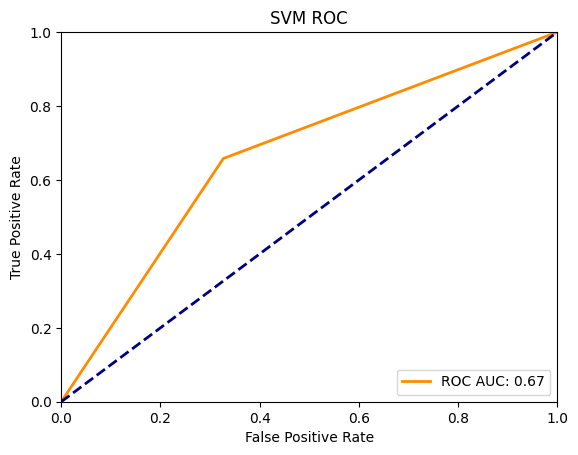

In [91]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC AUC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC')
plt.legend(loc="lower right")
plt.show()
scores = SVM.predict(X_test)

# Train Naive Bayes

In [92]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

# Get prediction accuracy

In [93]:
crossVal = cross_val_score(nb, X_train, y_train, cv=5)
print("Training Cross Validation: %0.2f" % (sum(crossVal) / float(len(crossVal)) * 100), "%")
accuracy = nb.score(X_test, y_test)
print("Test Accuraccy: ", accuracy * 100, "%")

Training Cross Validation: 65.49 %
Test Accuraccy:  59.11075197824181 %


# F1 Score

In [94]:
y_predicted = nb.predict(X_test)
print("F1 Score: ",f1_score(y_test, y_predicted))

F1 Score:  0.2226385402225636


# Confusion Matrix

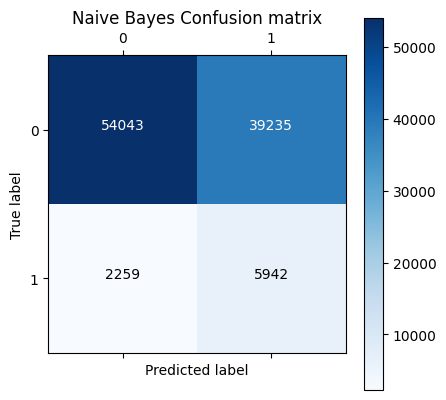

In [95]:
nb_confusion = metrics.confusion_matrix(y_test, y_predicted)
# nb_confusion = nb_confusion.astype('float') / nb_confusion.sum(axis=1)[:, np.newaxis]
plt.matshow(nb_confusion, cmap=plt.cm.Blues)
plt.grid(b=False)
plt.title("Naive Bayes Confusion matrix")
plt.colorbar()
thresh = nb_confusion.max() / 2.
for i, j in itertools.product(range(nb_confusion.shape[0]), range(nb_confusion.shape[1])):
    plt.text(j, i, nb_confusion[i, j],
    horizontalalignment="center",
    color="white" if nb_confusion[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
scores = nb.predict_proba(X_test)[:, 1]

# roc graph

In [96]:
fpr, tpr, _ = metrics.roc_curve(y_test, scores)
roc_auc = metrics.auc(fpr, tpr)

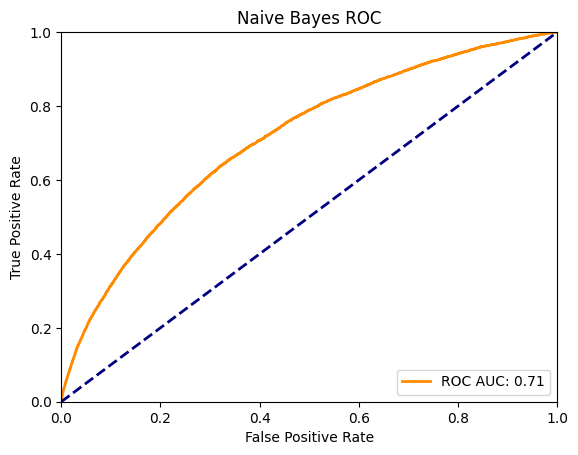

In [97]:
scores = nb.predict_proba(X_test)[:, 1]

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC AUC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes ROC')
plt.legend(loc="lower right")
plt.show()

# Train Adaboost

In [98]:
boost = AdaBoostClassifier(n_estimators=50)
boost.fit(X_train, y_train)

AdaBoostClassifier()

# Get prediction accuracy

In [99]:
crossVal = cross_val_score(boost, X_train, y_train, cv=5)
print("Training Cross Validation: %0.2f" % (sum(crossVal) / float(len(crossVal)) * 100), "%")
accuracy = boost.score(X_test, y_test)
print("Accuraccy: ", accuracy * 100, "%")

Training Cross Validation: 67.32 %
Accuraccy:  66.51918130844805 %


# F1 Score

In [100]:
y_predicted = boost.predict(X_test)
print("F1 Score: ",f1_score(y_test, y_predicted))

F1 Score:  0.24103113970423984


# Confusion Matrix

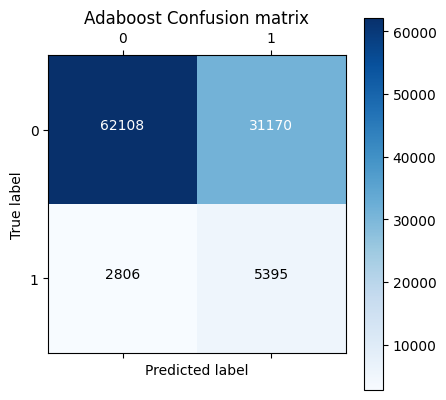

In [101]:
boost_confusion = metrics.confusion_matrix(y_test, y_predicted)
#boost_confusion = boost_confusion.astype('float') / boost_confusion.sum(axis=1)[:, np.newaxis]
plt.matshow(boost_confusion, cmap=plt.cm.Blues)
plt.grid(b=False)
plt.title("Adaboost Confusion matrix")
plt.colorbar()
thresh = boost_confusion.max() / 2.
for i, j in itertools.product(range(boost_confusion.shape[0]), range(boost_confusion.shape[1])):
    plt.text(j, i, boost_confusion[i, j],
    horizontalalignment="center",
    color="white" if boost_confusion[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
scores = boost.predict_proba(X_test)[:, 1]

# Roc graph

In [102]:
fpr, tpr, _ = metrics.roc_curve(y_test, scores)
roc_auc = metrics.auc(fpr, tpr)

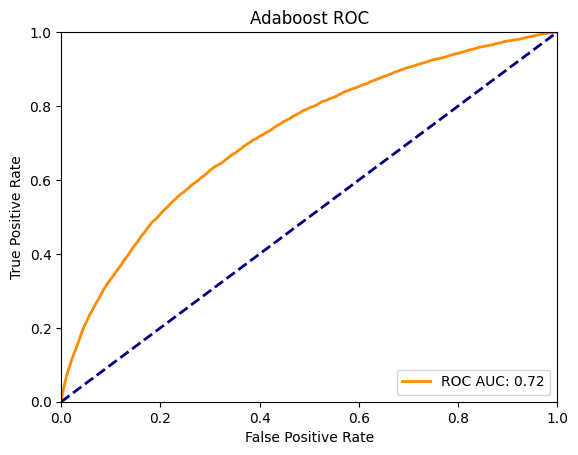

In [103]:
scores = boost.predict_proba(X_test)[:, 1]
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC AUC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Adaboost ROC')
plt.legend(loc="lower right")
plt.show()

# Train Random Forest

In [104]:
randomForest = RandomForestClassifier(n_estimators = 50, random_state = 50, n_jobs = -1)
randomForest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=50)

# Get prediction accuracy

In [105]:
crossVal = cross_val_score(randomForest, X_train, y_train, cv=5)
print("Training Cross Validation: %0.2f" % (sum(crossVal) / float(len(crossVal)) * 100), "%")
accuracy = randomForest.score(X_test, y_test)
print("Accuraccy: ", accuracy * 100, "%")

Training Cross Validation: 88.37 %
Accuraccy:  81.80904423575322 %


# F1 Score

In [106]:
y_predicted = randomForest.predict(X_test)
print("F1 Score: ",f1_score(y_test, y_predicted))

F1 Score:  0.20424174497801534


# Confusion Matrix

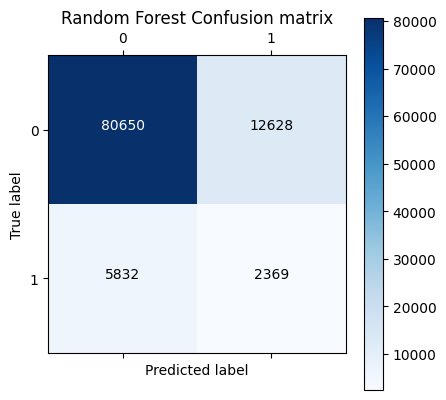

In [107]:
rf_confusion = metrics.confusion_matrix(y_test, y_predicted)
#rf_confusion = rf_confusion.astype('float') / rf_confusion.sum(axis=1)[:, np.newaxis]
plt.matshow(rf_confusion, cmap=plt.cm.Blues)
plt.grid(b=False)
plt.title("Random Forest Confusion matrix")
plt.colorbar()
thresh = rf_confusion.max() / 2.
for i, j in itertools.product(range(rf_confusion.shape[0]), range(rf_confusion.shape[1])):
    plt.text(j, i, rf_confusion[i, j],
    horizontalalignment="center",
    color="white" if rf_confusion[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
scores = randomForest.predict_proba(X_test)[:, 1]

# Roc Graph

In [108]:
fpr, tpr, _ = metrics.roc_curve(y_test, scores)
roc_auc = metrics.auc(fpr, tpr)

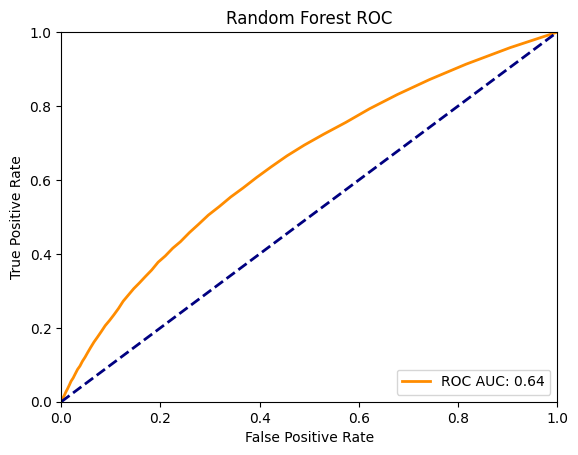

In [109]:
scores = randomForest.predict_proba(X_test)[:, 1]
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC AUC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right")
plt.show()

# Train NN

In [110]:
nn = MLPClassifier(solver='sgd', random_state=1)
nn.fit(X_train, y_train)

MLPClassifier(random_state=1, solver='sgd')

# Get prediction accuracy

In [111]:
crossVal = cross_val_score(nn, X_train, y_train, cv=5)
print("Training Cross Validation: %0.2f" % (sum(crossVal) / float(len(crossVal)) * 100), "%")
accuracy = nn.score(X_test, y_test)
print("Accuraccy: ", accuracy * 100, "%")

Training Cross Validation: 66.48 %
Accuraccy:  67.97958198247913 %


# F1 Score

In [112]:
y_predicted = nn.predict(X_test)
print("F1 Score: ",f1_score(y_test, y_predicted))

F1 Score:  0.24642857142857147


# Confusion Matrix

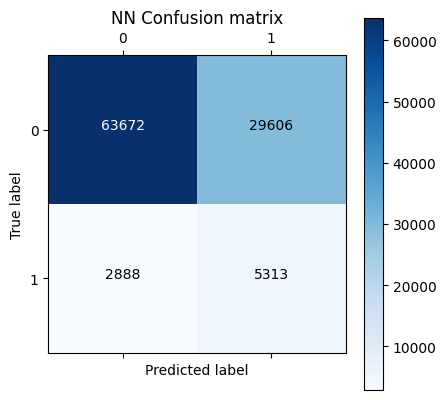

In [113]:
nn_confusion = metrics.confusion_matrix(y_test, y_predicted)
#nn_confusion = nn_confusion.astype('float') / nn_confusion.sum(axis=1)[:, np.newaxis]
plt.matshow(nn_confusion, cmap=plt.cm.Blues)
plt.grid(b=False)
plt.title("NN Confusion matrix")
plt.colorbar()
thresh = nn_confusion.max() / 2.
for i, j in itertools.product(range(nn_confusion.shape[0]), range(nn_confusion.shape[1])):
    plt.text(j, i, nn_confusion[i, j],
    horizontalalignment="center",
    color="white" if nn_confusion[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
scores = nn.predict_proba(X_test)[:, 1]

# Roc graph 

In [114]:
fpr, tpr, _ = metrics.roc_curve(y_test, scores)
roc_auc = metrics.auc(fpr, tpr)

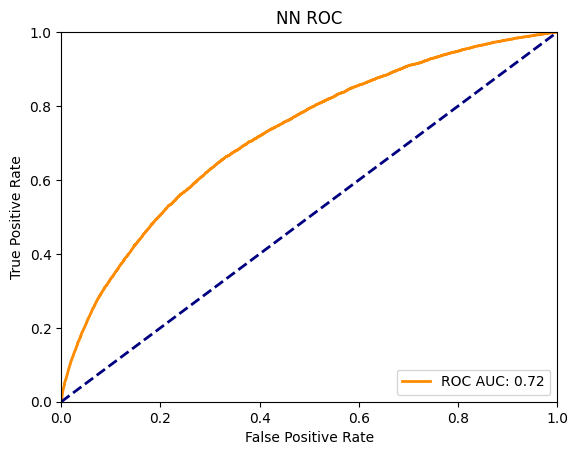

In [115]:
scores = nn.predict_proba(X_test)[:, 1]
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC AUC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NN ROC')
plt.legend(loc="lower right")
plt.show()